Wybierz zbiór danych z tych, które wykorzystywane były w module o regresji lub klasyfikacji. Dla któregoś z tych zbiorów stwórz Pipeline, w którym zawrzesz proces przygotowania danych i naucz nowy model, porównując go z tymi stworzonymi w tamtych modułach.

Zadanie wyślij Mentorowi w formie Notebooka zapisanego na Twoim repozytorium GitHub.

**Porównam model klasyfikacji pingwinów z poprzedniego zadania**

#Bibilioteki#

In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

#balansowanie ilosciami probek dla klas
from imblearn.over_sampling import SMOTE

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer, label_binarize

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

#Wczytanie pliku i podzial danych#

In [2]:
dataset = pd.read_csv('penguins.csv')
dataset

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


#Funkcja calculate_metrics#

In [3]:
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe

    # Predykcje i prawdopodobieństwa
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba)

    # **Metryki dla modelu**
    # Classification Report (dla binarnego i wieloklasowego problemu)
    print(classification_report(y_checked, predictions))

    # Confusion Matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.title('Confusion Matrix\n\n')
    plt.xlabel('\nPredicted Values')
    plt.ylabel('Actual Values')
    plt.show()

    # **Obsługa wieloklasowości**
    # Jeśli problem jest wieloklasowy, zbinaryzuj klasy
    classes = sorted(set(y_checked))
    is_multiclass = len(set(y_checked))

    if is_multiclass > 1:
        y_checked_binarized = label_binarize(y_checked, classes=classes)

        # F1-score (średnia ważona dla wieloklasowości)
        f1_metric = f1_score(y_checked, predictions, average='weighted')

        # AUC (dla podejścia one-vs-rest)
        auc_metric = roc_auc_score(y_checked_binarized, predictions_proba, multi_class='ovr')
    else:
        # F1-score (dla problemu binarnego)
        f1_metric = f1_score(y_checked, predictions)

        # AUC (dla problemu binarnego)
        auc_metric = roc_auc_score(y_checked, predictions_proba[:, 1])

    # Wykres ROC
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')

    # Check if y_checked_binarized and pred_proba have compatible shapes
    if y_checked_binarized.shape[0] != predictions_proba.shape[0]:
        print(f"Warning: Inconsistent number of samples. y_checked_binarized: {y_checked_binarized.shape}, predictions_proba: {predictions_proba.shape}")
        # Adjust shapes if necessary - this is a placeholder and may need to be tailored to your specific case
        max_samples = max(y_checked_binarized.shape[0], predictions_proba.shape[0])

        y_checked_binarized = np.resize(y_checked_binarized, (max_samples,y_checked_binarized.shape[1]))
        predictions_proba = np.resize(predictions_proba, (max_samples, predictions_proba.shape[1]))

        '''min_samples = min(y_checked_binarized.shape[0], predictions_proba.shape[0])
        y_checked_binarized = y_checked_binarized[:min_samples]
        predictions_proba = predictions_proba[:min_samples]'''

    # Inside the ROC curve plotting loop:
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        # Dla każdej klasy rysuj oddzielną krzywą ROC
        if is_multiclass > 1:  # Only apply this logic for multiclass cases
            # Ensure y_checked_binarized and pred_proba have the same number of samples:
            min_samples = min(y_checked_binarized.shape[0], pred_proba.shape[0])
            y_checked_binarized_subset = y_checked_binarized[:min_samples]
            pred_proba_subset = pred_proba[:min_samples]

            for i, cls in enumerate(classes):
                fpr, tpr, thresholds = roc_curve(y_checked_binarized_subset[:, i], pred_proba_subset[:, i])
                plt.plot(fpr, tpr, label=f"{name_selected} (class {cls})")
        else:  # For binary classification
            # Ensure y_checked and pred_proba have the same number of samples:
            min_samples = min(y_checked.shape[0], pred_proba.shape[0])
            y_checked_subset = y_checked[:min_samples]
            pred_proba_subset = pred_proba[:min_samples]

            fpr, tpr, thresholds = roc_curve(y_checked_subset, pred_proba_subset[:, 1])
            plt.plot(fpr, tpr, label=f"{name_selected}")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc=(1.05, 0.8))
    plt.show()

    # Dodanie wyników do globalnej tabeli
    metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame([{
        'Model': name,
        'F1_score': f1_metric,
        'AUC': auc_metric
    }])], ignore_index=True)

    return metrics_dataframe

#Poprzedni model#

In [4]:
penguins = dataset.copy()

In [5]:
# 2. Usunięcie brakujących danych
penguins_data_cleaned = penguins.dropna()

# 3. Wybór zmiennych numerycznych i targetu
numerical_columns = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']  # Zmienne numeryczne
target_column = 'Species'  # Target (klasa)

# Konwersja targetu do postaci numerycznej
penguins_data_cleaned['Species_numeric'] = penguins_data_cleaned['Species'].astype('category').cat.codes

# Podział na cechy (X) i target (y)
X = penguins_data_cleaned[numerical_columns]
y = penguins_data_cleaned['Species_numeric']

# 4. Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% trening, 30% test

# 5. Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Tworzenie cech wielomianowych
poly = PolynomialFeatures(degree=2, include_bias=False)  # Stworzenie interakcji i kwadratów
X_train_poly = poly.fit_transform(X_train_scaled)  # Dopasowanie i transformacja danych treningowych
X_test_poly = poly.transform(X_test_scaled)        # Transformacja danych testowych
poly_features = poly.get_feature_names_out(numerical_columns)

# 7. Balansowanie danych za pomocą SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

print("Rozmiar danych treningowych po balansowaniu:")
print(f"X_train_balanced: {X_train_balanced.shape}, y_train_balanced: {len(y_train_balanced)}")
print("Rozkład klas po balansowaniu:")
print(pd.Series(y_train_balanced).value_counts())

# 8. Redukcja wymiaru za pomocą PCA
pca = PCA(n_components=4)  # Redukcja do 4 głównych składowych
X_train_pca = pca.fit_transform(X_train_balanced)  # Dopasowanie PCA do danych zbalansowanych
X_test_pca = pca.transform(X_test_poly)           # Zastosowanie PCA na danych testowych

# 9. Utworzenie DataFrame dla PCA
train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(4)])
test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(4)])

# Dodanie klas do danych PCA
train_pca_df['Species_numeric'] = y_train_balanced
test_pca_df['Species_numeric'] = y_test

# 10. Obliczenie korelacji głównych składowych z klasą Species_numeric
pca_train_correlations = train_pca_df.corr(numeric_only=True)['Species_numeric'].drop('Species_numeric')

# Wyświetlenie wyników
pca_variance_ratios = pca.explained_variance_ratio_  # Wskaźnik wyjaśnionej wariancji przez każdą składową
print("Wyjaśniona wariancja dla każdej składowej PCA:", pca_variance_ratios)
print("Korelacje głównych składowych z klasą Species_numeric (trening):", pca_train_correlations.sort_values(ascending=False))

Rozmiar danych treningowych po balansowaniu:
X_train_balanced: (303, 14), y_train_balanced: 303
Rozkład klas po balansowaniu:
Species_numeric
0    101
1    101
2    101
Name: count, dtype: int64
Wyjaśniona wariancja dla każdej składowej PCA: [0.36583695 0.19614089 0.14893575 0.09177978]
Korelacje głównych składowych z klasą Species_numeric (trening): PC3    0.570431
PC2    0.367671
PC1   -0.210009
PC4   -0.466102
Name: Species_numeric, dtype: float64


<ipython-input-5-6c3c098d7d3e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_data_cleaned['Species_numeric'] = penguins_data_cleaned['Species'].astype('category').cat.codes


##Model Regresji Logistycznej##

In [6]:
model_lr = LogisticRegression(random_state = 42)

params_rf = {'penalty': ['l1', 'l2', 'elasticnet'],
             'solver': ['saga', 'lbfgs', 'liblinear'],
             'max_iter': [100, 1000, 10000],
             'C': [0.1, 1, 10],
             'l1_ratio': [0.1, 0.5, 0.7, 1.0]}

# Filtracja niepoprawnych kombinacji (dla elasticnet i l1)
valid_params = []
for penalty in ['l1', 'l2', 'elasticnet']:
    for solver in ['saga', 'lbfgs', 'liblinear']:
        if penalty == 'elasticnet' and solver != 'saga':
            continue
        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
            continue
        if penalty == 'none' and solver not in ['saga', 'lbfgs']:
            continue

        if penalty == 'elasticnet':
            valid_params.append({'penalty': [penalty], 'solver': [solver], 'l1_ratio': [0.1, 0.5, 0.7, 1.0]})
        else:
            valid_params.append({'penalty': [penalty], 'solver': [solver]})

# Przekształć listę filtracji na grid parametrów
param_grid = [{**param, 'max_iter': [100, 1000, 10000], 'C': [0.1, 1, 10]} for param in valid_params]

rf_gridsearch = GridSearchCV(model_lr,
                             param_grid,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10,
                             n_jobs=-1)
rf_gridsearch.fit(X_train_pca, y_train_balanced)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

model_lr = rf_model_v2.fit(X_train_pca, y_train_balanced)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best hyperparameter: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       1.00      1.00      1.00        34
           2       0.95      0.95      0.95        19

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103



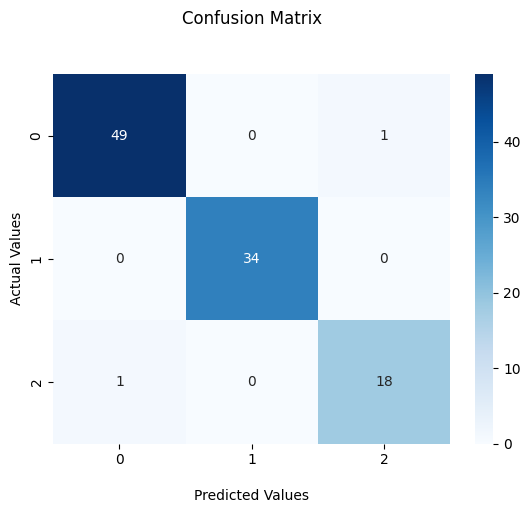

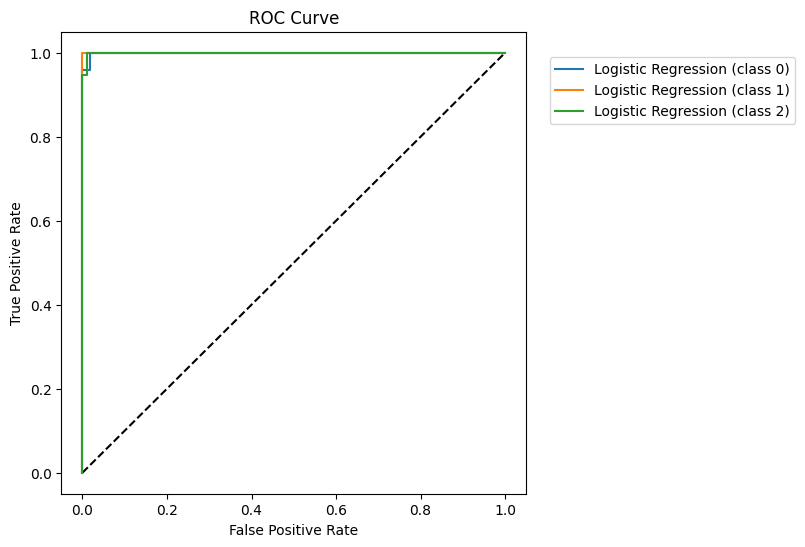

<ipython-input-3-5d108f61ba34>:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame([{


,Model,F1_score,AUC
0,Logistic Regression,0.980583,0.99954


In [7]:
calculate_metrics(model_lr, 'Logistic Regression', X_test_pca, y_test)

#Poprzedni model z pipeline#

In [8]:
num_features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
target = 'Species'

X = dataset[num_features].copy()
y = dataset[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

num_features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
target = 'Species'

X = dataset[num_features].copy()
y = dataset[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

model_lr_v2 = Pipeline(steps = [
    ('preprocessor', data_preparation),
    ('model', LogisticRegression(max_iter = 1000))
])
model_lr_v2.fit(X_train, y_train)

In [9]:
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

In [10]:
data_preparation = ColumnTransformer(transformers = [
    ('num_preparation', num_preparation, num_features)
])

In [11]:
model_lr_v2 = Pipeline(steps = [
    ('preprocessor', data_preparation),
    ('model', LogisticRegression(max_iter = 1000))
])

In [12]:
model_lr_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preparation',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [13]:
list(model_lr_v2.get_params().keys())

['memory',
 'steps',
 'transform_input',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__force_int_remainder_cols',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num_preparation',
 'preprocessor__num_preparation__memory',
 'preprocessor__num_preparation__steps',
 'preprocessor__num_preparation__transform_input',
 'preprocessor__num_preparation__verbose',
 'preprocessor__num_preparation__fill_missings',
 'preprocessor__num_preparation__polynomial_features',
 'preprocessor__num_preparation__scaler_1',
 'preprocessor__num_preparation__pca',
 'preprocessor__num_preparation__scaler_2',
 'preprocessor__num_preparation__fill_missings__add_indicator',
 'preprocessor__num_preparation__fill_missings__copy',
 'preprocessor__num_preparation__fill_missings__fill_value',
 'preprocessor__num_preparat

In [14]:
params = {'preprocessor__num_preparation__polynomial_features__degree' : [1, 2, 3, 4],
          'preprocessor__num_preparation__pca__n_components' : [0.85, 0.90, 0.95, 0.99, 0.9999],
          'model__C' : np.logspace(-4, 4, 50)
          }

grid_search = GridSearchCV(model_lr_v2, params, cv = 5, n_jobs = -1, verbose = 10, scoring = 'f1_macro', error_score= 'raise')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)

model_v2 = grid_search.best_estimator_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Wybrane hiperparametry:  {'model__C': 5.428675439323859, 'preprocessor__num_preparation__pca__n_components': 0.9, 'preprocessor__num_preparation__polynomial_features__degree': 4}


In [15]:
print(X_test.shape, y_test.shape)

(104, 4) (104,)


In [16]:
X_test_transformed = model_lr_v2.named_steps['preprocessor'].transform(X_test)
print(X_test_transformed.shape, y_test.shape)

(104, 3) (104,)


In [17]:
predictions = model_v2.predict(X_test)
predictions_proba = model_v2.predict_proba(X_test)

print("Shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("Predictions:", predictions.shape)
print("Predictions Proba:", predictions_proba.shape)

Shapes:
X_test: (104, 4)
y_test: (104,)
Predictions: (104,)
Predictions Proba: (104, 3)


In [18]:
f1_cross_val_scores = cross_val_score(model_v2, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross-validation scores shape:", f1_cross_val_scores.mean())

Cross-validation scores shape: 0.987910179489127


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      1.00      1.00        37
           2       1.00      0.95      0.98        21

    accuracy                           0.99       104
   macro avg       0.99      0.98      0.99       104
weighted avg       0.99      0.99      0.99       104



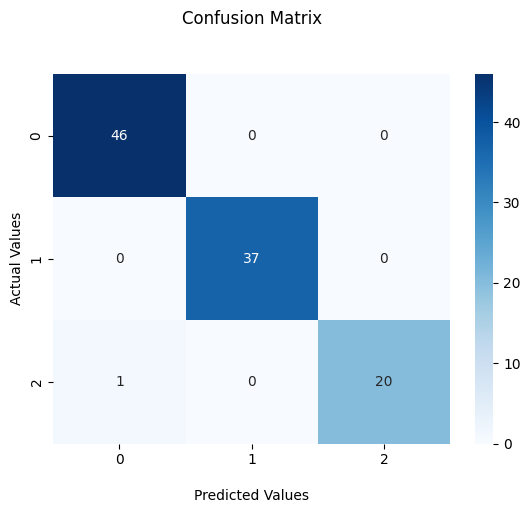

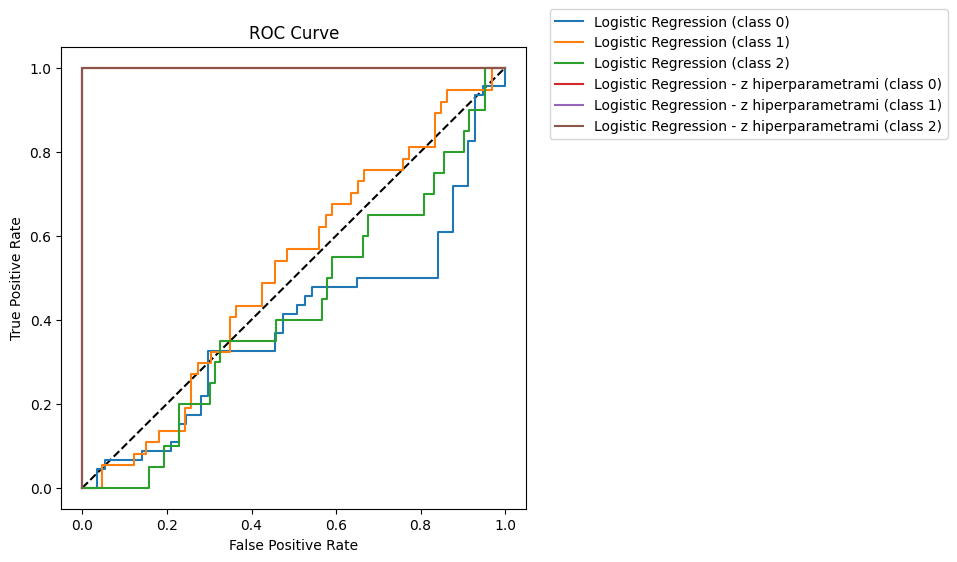

,Model,F1_score,AUC
0,Logistic Regression,0.980583,0.99954
1,Logistic Regression - z hiperparametrami,0.990319,1.00000


In [19]:
calculate_metrics(model_v2, 'Logistic Regression - z hiperparametrami', X_test, y_test)